# AMEX Default Prediction

## Set up

In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
pd.options.display.max_rows = 200
pd.options.display.max_info_columns = 200

## Data Import

In [63]:
# load data
train_data = pd.read_parquet('dataset/train.parquet')

In [64]:
raw_labels = pd.read_csv('dataset/train_labels.csv')

In [65]:
# fit train_labels to the same number length as train_data
customer_target_dict = dict(zip(raw_labels["customer_ID"], raw_labels["target"]))

In [66]:
train_labels = pd.DataFrame(data=train_data["customer_ID"], columns=["customer_ID"])
train_labels["target"] = train_data["customer_ID"].map(customer_target_dict)

## Data Preprocessing

Set nan/-1 value to the mean of their class for each feature

In [70]:
columns = train_data.columns[2:]
pbar = tqdm(range(len(columns)))

for it in pbar: 
    feature = columns[it]
    feature_data = train_data[feature]
    no_nan = feature_data.isnull().sum()
    no_neg_one = (feature_data == -1).sum()

    if no_nan > 0:
        complete_data = feature_data.loc[np.logical_not(feature_data.isnull())]
        complete_labels = train_labels.loc[complete_data.index]
        nan_data = feature_data.loc[feature_data.isnull()]
        nan_labels = train_labels.loc[nan_data.index]
    elif no_neg_one > 0:
        complete_data = feature_data.loc[np.logical_not(feature_data == -1)]
        complete_labels = train_labels.loc[complete_data.index]
        nan_data = feature_data.loc[feature_data == -1]
        nan_labels = train_labels.loc[nan_data.index]
    else:
        continue

    # split complete_data into 2 classes: default and not_default
    default_mask = complete_labels["target"] == 1
    default_indices = complete_labels.loc[default_mask].index
    default_data = complete_data.loc[default_indices]
    mean_default_data = np.average(default_data)

    ndefault_mask = complete_labels["target"] == 0
    ndefault_indices = complete_labels.loc[ndefault_mask].index
    ndefault_data = complete_data.loc[ndefault_indices]
    mean_ndefault_data = np.average(ndefault_data)

    # split nan_data into 2 classes: default and not_default
    default_mask = nan_labels["target"] == 1
    default_indices = nan_labels.loc[default_mask].index
    train_data.loc[default_indices, feature] = mean_default_data

    ndefault_mask = nan_labels["target"] == 0
    ndefault_indices = nan_labels.loc[ndefault_mask].index
    train_data.loc[ndefault_indices, feature] = mean_ndefault_data
    
    pbar.set_description('iter %d, feature: %s' % (it, feature))


iter 187, feature: D_145: 100%|██████████| 188/188 [01:25<00:00,  2.20it/s]


In [85]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,0.893908,0.008174,0.308362,0.0,0.0,0.0,0.401631,0.0,0.000610,0.0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,0.893908,0.008174,0.308362,0.0,0.0,0.0,0.401631,0.0,0.005492,0.0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,0.893908,0.008174,0.308362,0.0,0.0,0.0,0.401631,0.0,0.006986,0.0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,0.893908,0.008174,0.308362,0.0,0.0,0.0,0.401631,0.0,0.006527,0.0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,0.893908,0.008174,0.308362,0.0,0.0,0.0,0.401631,0.0,0.008126,0.0


## Dimensinality Reduction

In [78]:
from sklearn import decomposition

/Users/emmadang/opt/anaconda3/envs/amex/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [79]:
numerical_data = train_data.iloc[:,2:]

In [80]:
pca_model = decomposition.PCA(n_components=10)
pca_model.fit(numerical_data)

PCA(n_components=10)

In [84]:
pca_model.explained_variance_ratio_[0:2].sum()

0.9977320148935266

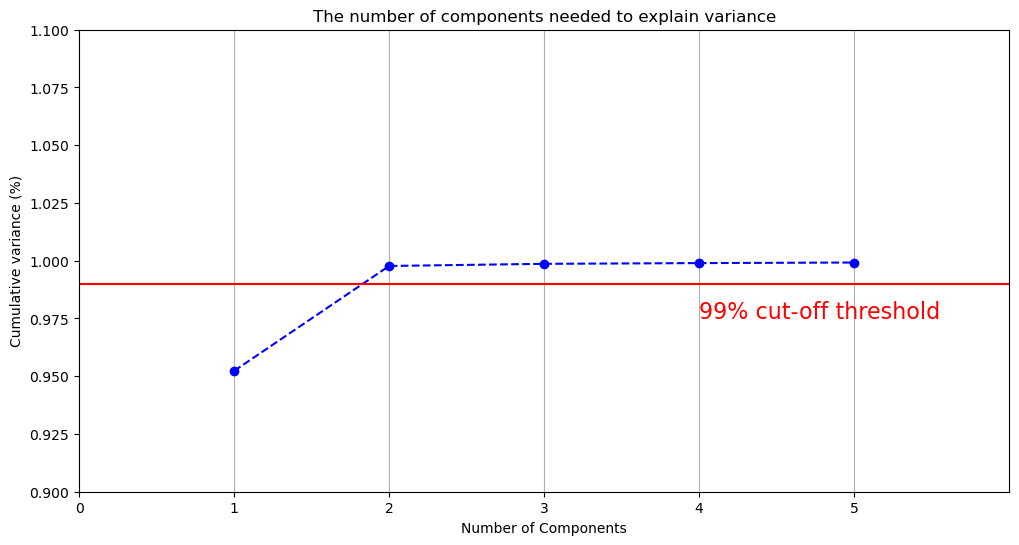

In [96]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 6 , step=1)
y = np.cumsum(pca_model.explained_variance_ratio_[:5])

plt.ylim(0.9,1.1)
plt.xlim(0,6)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 6, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(4, 0.975, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()